<a href="https://colab.research.google.com/github/anushapalisetty/Intel-Image-Classification/blob/main/tl_densenet_finetuned_val_accuracy_94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    break

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_train/seg_train/'
test_dir = '/content/drive/My Drive/Colab Notebooks/DL_Project_Data/seg_test/seg_test/'

In [4]:
nb = len(os.listdir(train_dir))
print(nb)

6


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
labels = os.listdir(train_dir)

In [7]:
def input_target_split(train_dir,labels):
    dataset = []
    count = 0
    for label in labels:
        folder = os.path.join(train_dir,label)
        for image in os.listdir(folder):
            img=load_img(os.path.join(folder,image), target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            dataset.append((img,count))
        print(f'\rCompleted: {label}',end='')
        count+=1
    random.shuffle(dataset)
    X, y = zip(*dataset)
    
    return np.array(X),np.array(y)
    
    

In [8]:
X_train, y_train = input_target_split(train_dir,labels)

Completed: buildings

In [9]:
X_test, y_test = input_target_split(test_dir,labels)

Completed: buildings

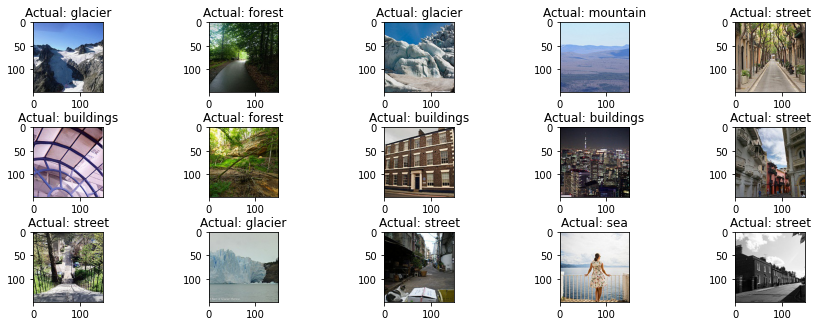

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X_train[i])
    plt.title(f'Actual: {labels[y_train[i]]}')

In [11]:
y_train = np.eye(nb)[y_train]
y_test = np.eye(nb)[y_test]

In [12]:
img_size = 150
base_model = DenseNet201(include_top = False,
                         weights = 'imagenet',
                         input_shape = (img_size,img_size,3))

for layer in base_model.layers[:675]:
    layer.trainable = False

for layer in base_model.layers[675:]:
    layer.trainable = True
    
# for (i,layer) in enumerate(base_model.layers):
#     print(str(i)+" "+layer.__class__.__name__,layer.trainable)

74842112/74836368 [==============================] - 4s 0us/step


In [13]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             rotation_range=20,
                             zoom_range=0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range=0.1,
                             fill_mode="nearest")

testgen = ImageDataGenerator()

datagen.fit(X_train)
testgen.fit(X_test)

In [14]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(nb, activation=tf.nn.softmax))
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
filepath= "/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_densenet_new.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

callbacks_list = [
        checkpoint,
        early_stopping,
        learning_rate_reduction
    ]

In [16]:
hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),
                                        validation_data=testgen.flow(X_test,y_test,batch_size=32),
                                        epochs=50,
                                        callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
440/440 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8619
Epoch 00001: val_accuracy improved from -inf to 0.91233, saving model to model_densenet.h5
440/440 [==============================] - 74s 169ms/step - loss: 0.3895 - accuracy: 0.8619 - val_loss: 0.2444 - val_accuracy: 0.9123
Epoch 2/50
440/440 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8982
Epoch 00002: val_accuracy improved from 0.91233 to 0.91733, saving model to model_densenet.h5
440/440 [==============================] - 71s 161ms/step - loss: 0.2810 - accuracy: 0.8982 - val_loss: 0.2386 - val_accuracy: 0.9173
Epoch 3/50
440/440 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9117
Epoch 00003: val_accuracy did not improve from 0.91733
440/440 [==============================] - 72s 163ms/step - loss: 0.2516 - accuracy: 0.9117 - val_loss: 0.2842 - val_accuracy: 0

In [17]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/DL_Project_Data/model_densenet_new.h5')

In [18]:
y_pred = model.predict(X_test)
pred = np.argmax(y_pred,axis=1)
print(pred)

[0 3 4 ... 3 4 5]


In [19]:
ground = np.argmax(y_test,axis=1)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(ground,pred,target_names = labels))

              precision    recall  f1-score   support

         sea       0.97      0.98      0.97       510
      street       0.94      0.95      0.95       501
      forest       0.98      0.99      0.98       474
    mountain       0.92      0.87      0.89       525
     glacier       0.88      0.90      0.89       553
   buildings       0.95      0.93      0.94       437

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [20]:
%matplotlib inline
acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()   